In [45]:
# load functions for data analysis
from adapting_fyp_analysis import experimental, visualizeStats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf    
import pandas, os, scipy
import numpy as np
import seaborn as sns

from scipy import stats

In [46]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [47]:
data_path = '/Users/biota/Desktop/sSL/experiment_2/collection/scr_data/'

In [48]:
day_one = experimental(data_path)
day_one.day = 1
day_one.preprocessData()

In [49]:
day_two = experimental(data_path)
day_two.day = 2
day_two.preprocessData()

In [50]:
cb = []; cb_name = []
bc = []; bc_name = []

for i_subject in range(0,len(day_two.subjectNames)): 
    
    subject_number = int(day_two.subjectNames[i_subject][1:3])
    
    condMarkers = np.copy(day_two.transData[i_subject][1])
    neg_ons = day_two.stimuli(condMarkers[:,1])[0]
    pos_ons = day_two.stimuli(condMarkers[:,0])[0]
    
    if pos_ons[0] > neg_ons[0]: 
        bc.append(i_subject)
        bc_name.append(subject_number)
    else: 
        cb.append(i_subject)
        cb_name.append(subject_number)
        
cb = np.array(cb)
bc = np.array(bc)

In [51]:
order = np.zeros(day_two.nSubjects)
order[cb] = 1

In [52]:

# first we remove non responders in the same way as in study 1 by threshholding the raw data across conditioning at .02 


In [53]:
start_con_onsets, end_con_onsets = 4, 13

conditioning_pos_raw = np.zeros([day_one.nSubjects,len(range(start_con_onsets,end_con_onsets))])
conditioning_neg_raw = np.zeros([day_one.nSubjects,len(range(start_con_onsets,end_con_onsets))])

day_one.nSeconds = 4.5
conditioning_inds = list(range(start_con_onsets, end_con_onsets))

for i_stim in range(0,len(conditioning_inds)):
    conditioning_pos_raw[:,i_stim], conditioning_neg_raw[:,i_stim] = day_one.amplitudeDifference('raw',
                                                                                   conditioning_inds[i_stim],
                                                                                   'offsets');

responders = np.array(mean(conditioning_pos_raw,1) > .02) #| np.array(mean(conditioning_neg_raw,1) > .02)

In [54]:

# first look for a main effect of CS on day two


In [55]:

iStim = 0
day_two.nSeconds = 4.5
renewal_minus, renewal_plus = day_two.amplitudeDifference('trans',iStim,'onset');


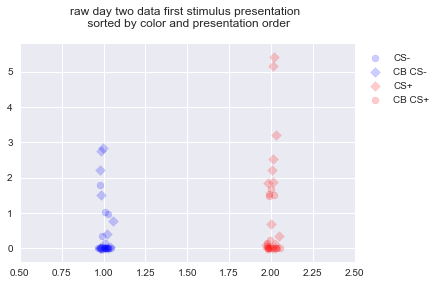

In [56]:

tmp_alpha = .2
tmp_len = len(np.nonzero(order==False)[0])
sns.set_style("dark", {'axes.grid' : True})
cb_jitter = np.random.randn(len(cb))/50
bc_jitter = np.random.randn(len(bc))/50

scatter(np.ones(tmp_len) + bc_jitter,
        renewal_minus[order==False], 
        color='blue',alpha=tmp_alpha, label='CS-')

scatter(np.ones(sum(order==True)) + cb_jitter, 
        renewal_minus[order==True], 
        color='blue',marker='D', alpha=tmp_alpha,label='CB CS-')

scatter(np.ones(tmp_len)+1 + bc_jitter,
        renewal_plus[order==False], 
        color='red',marker='D',alpha=tmp_alpha, label='CS+')

scatter(np.ones(sum(order==True))+1 + cb_jitter,
        renewal_plus[order==True], 
        color='red',alpha=tmp_alpha,label='CB CS+')

xlim(.5,2.5) ; #ylim(-.3,2.3); 
legend(bbox_to_anchor=(1.25, 1)) ; 
title('raw day two data first stimulus presentation \n sorted by color and presentation order\n')


In [57]:

# find amplitude over the first two trials


In [58]:

block_length = 2
day_two.nSeconds = 4.5

pos_renewal_stims = np.zeros([day_two.nSubjects, block_length])
neg_renewal_stims  = np.zeros([day_two.nSubjects, block_length])

for i_stim in range(block_length):  
    neg_renewal_stims[:, i_stim], pos_renewal_stims[:, i_stim] = day_two.amplitudeDifference('trans',
                                                                                              i_stim,
                                                                                             'onset')

In [59]:

# controll for learning on day one like we did in part one of the study


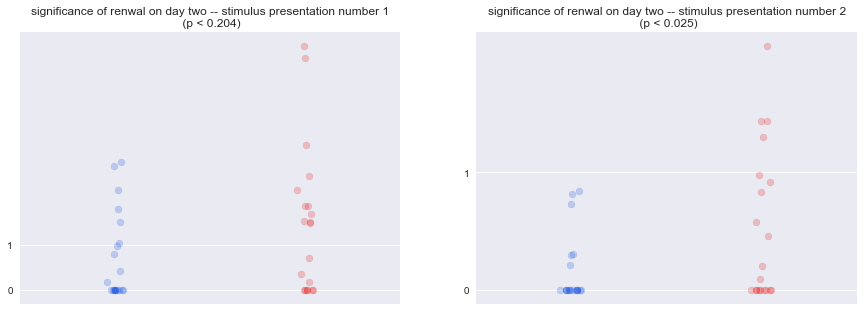

In [61]:
figure(figsize=[15,5])
for i_stim in [0,1]: 
    
    p_renewal = stats.wilcoxon(neg_renewal_stims[:,i_stim][responders], 
                               pos_renewal_stims[:,i_stim][responders])[1]
    subplot(1,2,i_stim+1)
    x_locations = np.zeros(sum(responders)) + np.random.randn(sum(responders))/50
    scatter(x_locations,   neg_renewal_stims[responders,i_stim], alpha=.2, color='xkcd:blue')
    scatter(x_locations+1, pos_renewal_stims[responders,i_stim], alpha=.2, color='xkcd:red')
    title('significance of renwal on day two -- stimulus presentation number %s\n (p < %.3f)'
          %(str(i_stim + 1), p_renewal))
    xlim(-.5,1.5); xticks([]); yticks([0,1])


In [76]:
neg_block_renewal = mean(neg_renewal_stims,1)[responders]
pos_block_renewal = mean(pos_renewal_stims,1)[responders]


In [63]:
_, p_renewal = stats.wilcoxon(neg_block_renewal, pos_block_renewal)

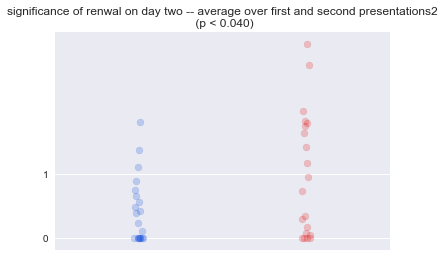

In [65]:
x_locations = np.zeros(sum(responders)) + np.random.randn(sum(responders))/50

scatter(x_locations,   neg_block_renewal, alpha=.2, color='xkcd:blue')
scatter(x_locations+1, pos_block_renewal, alpha=.2, color='xkcd:red')


title('significance of renwal on day two -- average over first and second presentations%s\n (p < %.3f)'
      %(str(i_stim + 1), p_renewal))
xlim(-.5,1.5)  ; xticks([]) ; yticks([0,1]); 


In [66]:
neg_block_renewal

array([ -1.54253667e-04,  -1.12092045e-04,   2.33595718e-01,
         6.62923649e-01,   3.91924609e-01,  -7.87680247e-05,
         4.84195412e-01,  -1.18312143e-04,  -1.10744277e-04,
         8.95844441e-01,  -5.37703755e-05,   4.18764959e-01,
         5.66615641e-01,   1.06554206e-01,  -2.45117679e-05,
         1.10993269e+00,  -5.35388547e-05,   1.37810285e+00,
         1.82282623e+00,   7.56240120e-01])

In [20]:

log_renewal_plus  = log(1 + renewal_plus)
log_renewal_minus = log(1 + renewal_minus)
log_renewal =  log_renewal_plus - log_renewal_minus 


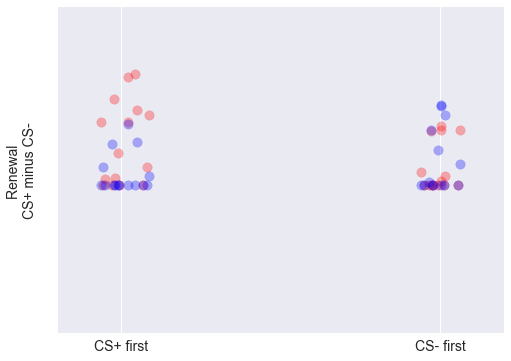

In [21]:

figure(figsize=[8,6])

jitter = np.random.randn(len(order))/20
scatter(order + jitter, log_renewal_plus, color='red', alpha=.3, s=90)
scatter(order + jitter, log_renewal_minus, color='blue', alpha=.3, s=90)

ylabel('Renewal \nCS+ minus CS-\n', rotation=90, fontsize=14)
yticks([]) 
xticks([0, 1],['CS+ first','CS- first'], fontsize=14)
xlim(-.2, 1.2)  ; ylim(-2.5, 3); 


In [22]:

# find measure of learning on day one


In [23]:
start_con_onsets = 4
end_con_onsets   = 13
conditioning_pos_onsets = np.zeros([day_one.nSubjects,len(range(start_con_onsets,end_con_onsets))])
conditioning_neg_onsets = np.zeros([day_one.nSubjects,len(range(start_con_onsets,end_con_onsets))])

day_one.nSeconds = 4.5
conditioning = list(range(start_con_onsets,end_con_onsets))

for i_stim in range(0,len(conditioning)):
    conditioning_pos_onsets[:,i_stim], conditioning_neg_onsets[:,i_stim] = day_one.amplitudeDifference('raw',
                                                                           conditioning[i_stim],
                                                                           'onset');
conditioning_significance_onsets = np.zeros(day_one.nSubjects)

for i_subject in range(0,day_one.nSubjects): 
    conditioning_significance_onsets[i_subject] = scipy.stats.wilcoxon(conditioning_pos_onsets[i_subject,:],
                                                                 conditioning_neg_onsets[i_subject,:])[1]
    
log_conditioning_pos_onsets = log(1 + conditioning_pos_onsets)
log_conditioning_neg_onsets = log(1 + conditioning_neg_onsets)

# final learning metric on day one
log_learning = mean(log_conditioning_pos_onsets - log_conditioning_neg_onsets,1)

In [24]:

log_renewal_plus  = log(1 + mean(pos_renewal_stims,1)) # log(1 + renewal_plus)
log_renewal_minus = log(1 + renewal_minus)
log_renewal =  log_renewal_plus - log_renewal_minus 


In [25]:
responders = np.array(mean(conditioning_pos_raw,1) > .02) | np.array(mean(conditioning_neg_raw,1) > .01)
responders

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True, False,  True,
        True,  True], dtype=bool)

In [26]:
np.nonzero(responders)[0], responders


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 20, 21, 22, 23, 24, 26, 27, 28]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True, False,  True,
         True,  True], dtype=bool))

In [87]:
pos_renewal_stims[:,0].shape

(29,)

In [95]:

# backbone of the physiological response analysis
SCR = pandas.DataFrame({   
                           'renewal':log_renewal[responders], 
                          'learning':log_learning[responders], 
                             'order':order[responders], 
                            'block_renewal':np.array(pos_block_renewal-neg_block_renewal)
    
                       })

subject_names = [day_two.subjectNames[i_subject][1:3] for i_subject in np.nonzero(responders)[0]]
#subject_names = [day_two.subjectNames[i_subject][1:3] for i_subject in range(len(order))]
SCR.index = subject_names


len(SCR.index)

20

In [94]:
# SCR = SCR.drop('40') #   not a naive subject
# SCR = SCR.drop('42') # tyler fucked up protocol

# SCR = SCR.drop('44') 
# SCR = SCR.drop('41') 
# SCR = SCR.drop('25')
# SCR = SCR.drop('28')

In [99]:

formula = 'block_renewal ~ learning'
model_prediction_responders = ols(formula, SCR).fit()
aov_table_responders = anova_lm(model_prediction_responders, typ=2)
print '\n\n\t\t', formula, '\n\n', aov_table_responders

formula = 'block_renewal ~ learning + C(order)'
model_prediction_order_responders = ols(formula, SCR).fit()
aov_table_order_responders = anova_lm(model_prediction_order_responders, typ=2)
p_value = aov_table_order_responders.values[2,3]
print '\n\n\t', formula, '\n\n', aov_table_order_responders, '\n\n'

p_value_responders_order_prediction = aov_table_order_responders.values[1,3]
p_value_responders_prediction = aov_table_responders.values[0,3]




		block_renewal ~ learning 

             sum_sq    df         F    PR(>F)
learning   6.857619   1.0  9.286478  0.006932
Residual  13.292136  18.0       NaN       NaN


	block_renewal ~ learning + C(order) 

            sum_sq    df         F    PR(>F)
C(order)  3.523781   1.0  6.132484  0.024083
learning  2.443748   1.0  4.252888  0.054810
Residual  9.768355  17.0       NaN       NaN 




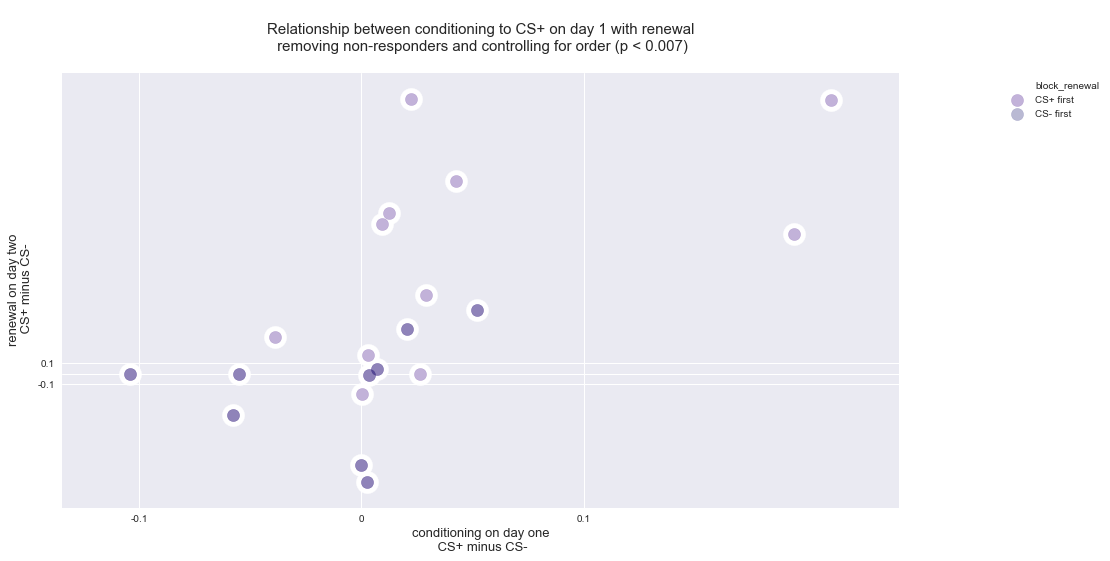

In [100]:
figure(figsize=(15,8))

scatter(SCR['learning'], SCR['block_renewal'], color='xkcd:white', alpha=1,s=500)
scatter(SCR['learning'], SCR['block_renewal'], color='xkcd:indigo',alpha=.3,s=150, label='CS+ first')
scatter(SCR['learning'][SCR['order'] == True], SCR['block_renewal'][SCR['order']  == True], color='midnightblue',alpha=.3, s=150,  label='CS- first')
sns.set_style("dark", {'axes.grid' : True})
legend(bbox_to_anchor=(1.25, 1)) 
xlabel('conditioning on day one\n CS+ minus CS-',fontsize=13)
ylabel('renewal on day two\n CS+ minus CS-',fontsize=13)
yticks([-.1,0,.1],[-.1,'',.1])
xticks([-.1,0,.1],[-.1,0,.1])

responder_names = np.array(day_two.subjectNames)[responders]

# for i_subject in range(len(SCR.index)):
#     plt.annotate(SCR.index[i_subject], xy=(SCR['learning'][i_subject], SCR['renewal'][i_subject]), 
#                  xytext=(-20, -25), textcoords='offset points', alpha=1, fontsize=15)

title('\nRelationship between conditioning to CS+ on day 1 with renewal\n removing non-responders and controlling for order (p < %.03f)\n' 
      %(p_value_responders_prediction), fontsize=15); 

In [103]:

formula = 'renewal ~ learning'
model_prediction_responders = ols(formula, SCR).fit()
aov_table_responders = anova_lm(model_prediction_responders, typ=2)
print '\n\n\t\t', formula, '\n\n', aov_table_responders

formula = 'renewal ~ learning + C(order)'
model_prediction_order_responders = ols(formula, SCR).fit()
aov_table_order_responders = anova_lm(model_prediction_order_responders, typ=2)
p_value = aov_table_order_responders.values[2,3]
print '\n\n\t', formula, '\n\n', aov_table_order_responders, '\n\n'

p_value_responders_order_prediction = aov_table_order_responders.values[1,3]
p_value_responders_prediction = aov_table_responders.values[0,3]




		renewal ~ learning 

            sum_sq    df         F    PR(>F)
learning  1.714024   1.0  4.501288  0.048009
Residual  6.854132  18.0       NaN       NaN


	renewal ~ learning + C(order) 

            sum_sq    df         F    PR(>F)
C(order)  1.918713   1.0  6.608986  0.019841
learning  0.348508   1.0  1.200432  0.288515
Residual  4.935419  17.0       NaN       NaN 




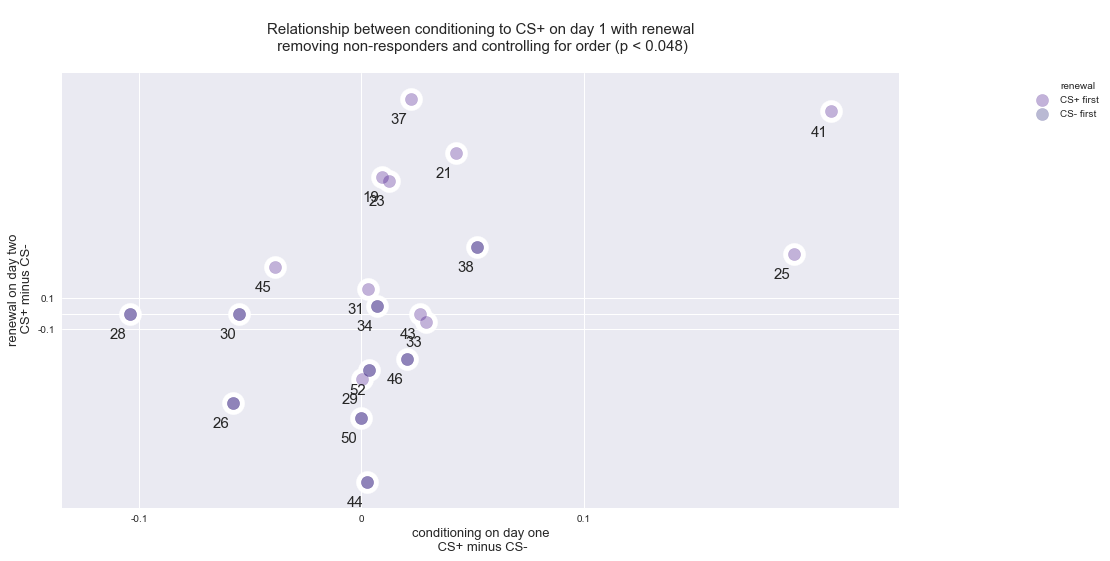

In [104]:
figure(figsize=(15,8))

scatter(SCR['learning'], SCR['renewal'], color='xkcd:white', alpha=1,s=500)
scatter(SCR['learning'], SCR['renewal'], color='xkcd:indigo',alpha=.3,s=150, label='CS+ first')
scatter(SCR['learning'][SCR['order'] == True], SCR['renewal'][SCR['order']  == True], color='midnightblue',alpha=.3, s=150,  label='CS- first')
sns.set_style("dark", {'axes.grid' : True})
legend(bbox_to_anchor=(1.25, 1)) 
xlabel('conditioning on day one\n CS+ minus CS-',fontsize=13)
ylabel('renewal on day two\n CS+ minus CS-',fontsize=13)
yticks([-.1,0,.1],[-.1,'',.1])
xticks([-.1,0,.1],[-.1,0,.1])

responder_names = np.array(day_two.subjectNames)[responders]

for i_subject in range(len(SCR.index)):
    plt.annotate(SCR.index[i_subject], xy=(SCR['learning'][i_subject], SCR['renewal'][i_subject]), 
                 xytext=(-20, -25), textcoords='offset points', alpha=1, fontsize=15)

title('\nRelationship between conditioning to CS+ on day 1 with renewal\n removing non-responders and controlling for order (p < %.03f)\n' 
      %(p_value_responders_prediction), fontsize=15); 

In [41]:


block_length = 2
day_two.nSeconds = 4.5

block_renewal_minus = np.zeros([day_two.nSubjects, block_length])
block_renewal_plus  = np.zeros([day_two.nSubjects, block_length])

for i_stim in range(block_length):  

    block_renewal_minus[:, i_stim], block_renewal_plus[:, i_stim] = day_two.amplitudeDifference('trans',
                                                                                                i_stim,
                                                                                                'onset')

Ttest_indResult(statistic=1.9798903928594325, pvalue=0.053019584848876505)

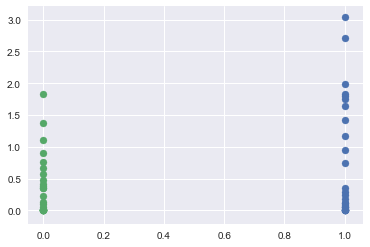

In [42]:
scatter(np.ones(day_two.nSubjects), np.mean(block_renewal_plus,1))
scatter(np.zeros(day_two.nSubjects), np.mean(block_renewal_minus,1))

block_renewal =  np.mean(block_renewal_plus,1) - np.mean(block_renewal_minus,1)

stats.ttest_ind(np.mean(block_renewal_plus,1)[responders], np.mean(block_renewal_minus,1)[responders])

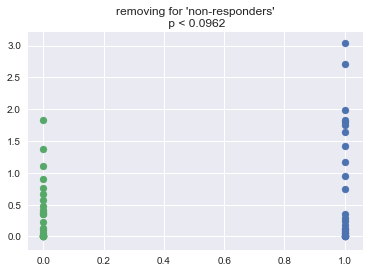

In [43]:

block_length = 2
day_two.nSeconds = 4.5

raw_block_renewal_minus = np.zeros([day_two.nSubjects, block_length])
raw_block_renewal_plus  = np.zeros([day_two.nSubjects, block_length])

for i_stim in range(block_length):  

    raw_block_renewal_minus[:, i_stim], raw_block_renewal_plus[:, i_stim] = day_two.amplitudeDifference('raw',
                                                                                                        i_stim,
                                                                                                        'onset')
keep_data =  np.array(raw_block_renewal_plus[:,0]  > .01) | np.array(raw_block_renewal_minus[:,0]  > .02)                                                                     
block_renewal =  np.mean(block_renewal_plus,1)[keep_data] - np.mean(block_renewal_minus,1)[keep_data]

aa = np.mean(block_renewal_plus,1)[keep_data]
bb = np.mean(block_renewal_minus,1)[keep_data]

_,p = stats.wilcoxon(aa,bb)

scatter(np.ones(len(aa)), aa)
scatter(np.zeros(len(bb)), bb)
title("removing for 'non-responders'\n p < %.4f"%p)

In [ ]:
mean(raw_block_renewal_plus[bc,0]), mean(raw_block_renewal_plus[cb,0])

In [ ]:
stats.ttest_ind(raw_block_renewal_minus[bc,0], raw_block_renewal_minus[bc,1])

In [ ]:
# first just check that we've got the right counterbalanced assignments. 
# this is tricky because i fucked up the channels i'm using when signaling the biopac somehow
# the problem is probably in experiment_2/collection/design_parameters.py
# in every case, we know that the second CS channel is the CS+ (empirically )

def show_raw_data(i_subject, cb): 
    figure(figsize=[20,1])
    plot(day_one.rawData[i_subject][:,0], label='scr')
    plot(day_one.rawData[i_subject][:,1], label='cs-', color='blue', alpha=.2, linewidth=3)
    plot(day_one.rawData[i_subject][:,2], label='cs+', color='red', alpha=.2, linewidth=3)
    title('%s, counterbalanced = %s'%(day_two.subjectNames[i_subject], order[i_subject]), fontsize=15)
    legend(fontsize=10);     
#### validates CB locations for wonkey day two condition channels

for i_subject in range(day_two.nSubjects): 
    show_raw_data(i_subject,1) 
